## Notebook Description
This notebook is dedicated to basic EDA on the clean data read in from the `clean_data` folder. It will look at the data in one dataframe, then split the data into two dataframes (one for each Subreddit), to look at the data independently.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('../clean_data/reddit_clean.csv')
df.head()

,title,selftext,subreddit,created_utc
0,"Where to backpack 4 nights in Utah, Arizona, o...",Hello Reddit folks! Four of my friends and I a...,backpacking,1646011972
1,"Peace Walls, Belfast",NaN,backpacking,1646007041
2,How To Mount Snowshoes On Osprey Talon 22 Back...,"The backpack is fairly small, but the suspensi...",backpacking,1646005307
3,Bringing dog to Kearsarge pass?,[removed],backpacking,1646004876
4,Mid 30s short trip to Thailand - Bangkok &amp;...,My husband and I plan to go to Thailand for a ...,backpacking,1646000495


In [3]:
df.isnull().sum()

title             0
selftext       1431
subreddit         0
created_utc       0
dtype: int64

In [4]:
df['selftext'] = df['selftext'].fillna('')
df.isnull().sum()

title          0
selftext       0
subreddit      0
created_utc    0
dtype: int64

## EDA on Original DF

In [5]:
df.shape

(3999, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        3999 non-null   object
 1   selftext     3999 non-null   object
 2   subreddit    3999 non-null   object
 3   created_utc  3999 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [7]:
df.describe()

,created_utc
count,3.999000e+03
mean,1.636583e+09
std,9.181059e+06
min,1.613961e+09
25%,1.629830e+09
50%,1.641260e+09
75%,1.643595e+09
max,1.646012e+09


In [8]:
df.groupby('subreddit')['selftext'].count()

subreddit
backpacking     1999
ultrarunning    2000
Name: selftext, dtype: int64

### Analyze the Timing of Reddit Submmissions
This is just typical EDA, where I am unsure if I will find any sort of patterns here; however, I wanted to see the temporal aspect

In [9]:
# Length of time between first and last post in df
pd.to_datetime(df['created_utc'].max(), unit='s') - pd.to_datetime(df['created_utc'].min(), unit='s')

Timedelta('370 days 22:56:37')

#### Creating New Time Columns

In [10]:
# Creates EST time from UTC
df['created_est'] = pd.to_datetime(df['created_utc'], unit='s')


# Returns only yyy-mm-dd format from `created_est`
# Source: # https://stackoverflow.com/questions/38516251/valueerror-cannot-cast-datetimeindex-to-dtype-datetime64us
df['date_posted'] = df['created_est'].dt.to_period('M').apply(lambda d: pd.to_datetime(str(d)))


# Creates a Month Name column
df['month_name'] = df['date_posted'].dt.month_name()


# Converts month_name to type CategoricalDtype
# Source https://towardsdatascience.com/ridgeline-plots-the-perfect-way-to-visualize-data-distributions-with-python-de99a5493052

from pandas.api.types import CategoricalDtype

cat_month = CategoricalDtype(
    ['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December']
)

df['month_name'] = df['month_name'].astype(cat_month)

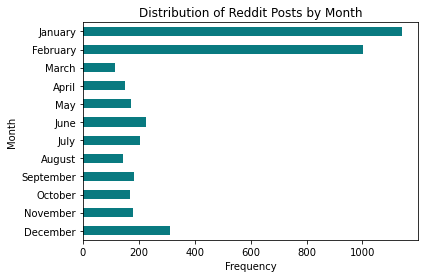

In [14]:
# Reddit Posts by Month... I'm curious if one subreddit posts more often in certain months than the other. 
# I didn't have time to analyze this though unfortunately.

df.sort_values('month_name',ascending=False).groupby('month_name', sort=False)['date_posted'].count().plot.barh(color = '#097a80')
plt.title("Distribution of Reddit Posts by Month")
plt.xlabel("Frequency")
plt.ylabel("Month")
plt.savefig("../graphics/Distribution_of_Reddit_Posts_by_month.jpg", bbox_inches="tight", dpi=100); #save as jpg;;

In [15]:
df.head()

,title,selftext,subreddit,created_utc,created_est,date_posted,month_name
0,"Where to backpack 4 nights in Utah, Arizona, o...",Hello Reddit folks! Four of my friends and I a...,backpacking,1646011972,2022-02-28 01:32:52,2022-02-01,February
1,"Peace Walls, Belfast",,backpacking,1646007041,2022-02-28 00:10:41,2022-02-01,February
2,How To Mount Snowshoes On Osprey Talon 22 Back...,"The backpack is fairly small, but the suspensi...",backpacking,1646005307,2022-02-27 23:41:47,2022-02-01,February
3,Bringing dog to Kearsarge pass?,[removed],backpacking,1646004876,2022-02-27 23:34:36,2022-02-01,February
4,Mid 30s short trip to Thailand - Bangkok &amp;...,My husband and I plan to go to Thailand for a ...,backpacking,1646000495,2022-02-27 22:21:35,2022-02-01,February


<Figure size 432x288 with 0 Axes>

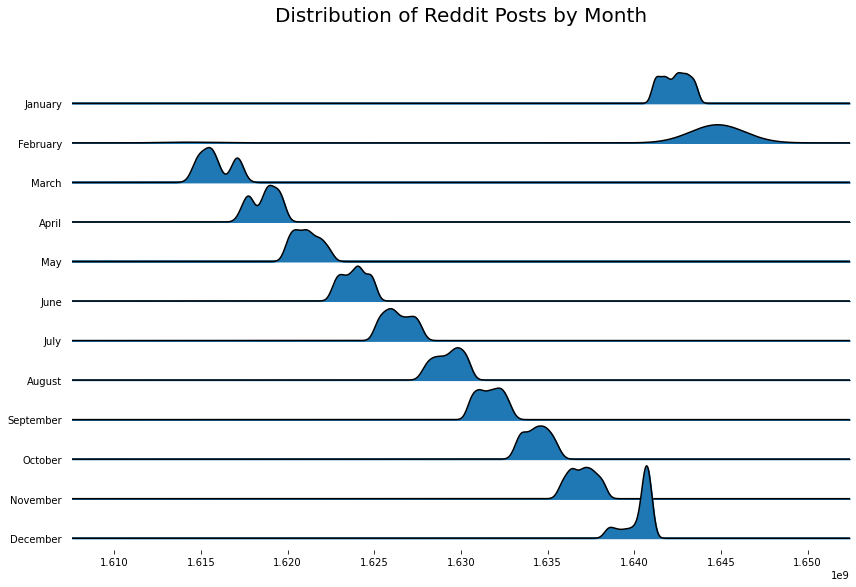

In [16]:
# This is the same as above, I am just trying to learn new ways of displaying the data
# Source: https://towardsdatascience.com/ridgeline-plots-the-perfect-way-to-visualize-data-distributions-with-python-de99a5493052

from joypy import joyplot

plt.figure()

joyplot(
    data=df[['created_utc', 'month_name']], 
    by='month_name',
    figsize=(12, 8),
    overlap=1
)
plt.title('Distribution of Reddit Posts by Month', fontsize=20)
plt.ylabel('Month')
plt.savefig("../graphics/Distribution_of_Reddit_Posts_by_month_Ridgeline.jpg", bbox_inches="tight", dpi=100); #save as jpg

## Baseline Model

In [89]:
# Baseline model
# Need my model to be better than .50

df['subreddit'].value_counts(normalize=True)

ultrarunning    0.500125
backpacking     0.499875
Name: subreddit, dtype: float64

## Set up for CountVectorizer

In [90]:
# Set up for CountVectorizer

X = df['title']
y = df['subreddit']

In [91]:
# Test/Train/Split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [92]:
# Instantiate a CountVectorizer with the default hyperparamters
cvec = CountVectorizer(stop_words='english')

# Fit the vectorizer on my corpus
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [93]:
# Transform the corpus
X_train = cvec.transform(X_train)

# Transform test
X_test = cvec.transform(X_test)

In [94]:
# View some of the feature_names

cvec.get_feature_names()[1000:1010]

['cheeks',
 'cheers',
 'chemo',
 'chew',
 'chi',
 'chicago',
 'chicagoland',
 'chicken',
 'children',
 'chile']

In [95]:
X_train_df = pd.DataFrame(X_train.todense(),
                         columns=cvec.get_feature_names())

In [96]:
X_train_df.head()

,000,000ft,000m,01,02,022,03,05,07,0c,...,للاندرويد,مباشر,مجانا,من,نیاز,والاجراءات,والتسهيلات,کمک,گروه,یه
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA on CountVectorized Title

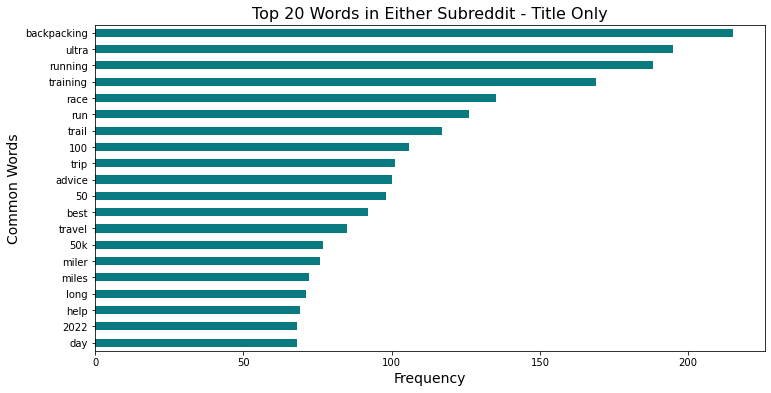

In [97]:
# Top 20 occurring words in either subreddits - using only Title column

X_train_df.sum(numeric_only=True).sort_values(ascending=True).tail(20).plot.barh(figsize=(12,6), color = '#097a80')
plt.xlabel('Frequency', fontdict= {'fontsize':14})
plt.ylabel('Common Words', fontdict= {'fontsize':14})
plt.title('Top 20 Words in Either Subreddit - Title Only', fontdict = {'fontsize':16})
plt.savefig("../graphics/Top_20_words_either_subreddit_title_only.jpg", bbox_inches="tight", dpi=100); #save as jpg

## Splitting Dataframe by Subreddits

In [98]:
df_backpacking = df[df['subreddit'] == 'backpacking']
df_backpacking.shape

(1999, 7)

In [99]:
df_ultrarunning = df[df['subreddit'] == 'ultrarunning']
df_ultrarunning.shape

(2000, 7)

In [100]:
df_ultrarunning.head()

,title,selftext,subreddit,created_utc,created_est,date_posted,month_name
1999,Hamstring? IT Band? Anyone have any idea what'...,"Hey all, so I (38M) am a long time runner and ...",ultrarunning,1645998486,2022-02-27 21:48:06,2022-02-01,February
2000,Kodiak 100 Big Bear,Has anyone else signed up for this August 19 a...,ultrarunning,1645974508,2022-02-27 15:08:28,2022-02-01,February
2001,What's your recovery food/supplementation for ...,I've started doing a lot of 10-30 mile runs as...,ultrarunning,1645967199,2022-02-27 13:06:39,2022-02-01,February
2002,What's your best advice for bullet-proof quads?,After having run my first 100k a few weeks ago...,ultrarunning,1645949692,2022-02-27 08:14:52,2022-02-01,February
2003,1955 Ultra finisher awards,\n\nhttps://preview.redd.it/5ggahv5be8k81.jpg...,ultrarunning,1645904750,2022-02-26 19:45:50,2022-02-01,February


### CountVectorize & EDA for Backpacking Subreddit

In [101]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_backpacking['title'])
csr = cvec.transform(df_backpacking['title'])
df_backpacking = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

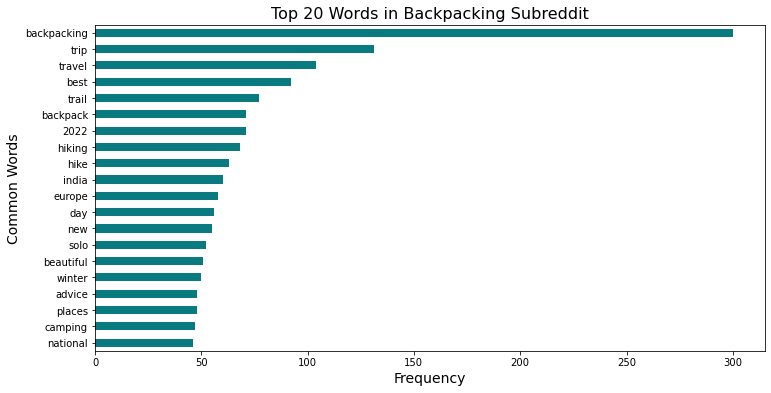

In [102]:
# Top 20 occurring words in Backpacking subreddit

df_backpacking.sum(numeric_only=True).sort_values(ascending=True).tail(20).plot.barh(figsize=(12,6), color = '#097a80')
plt.xlabel('Frequency', fontdict= {'fontsize':14})
plt.ylabel('Common Words', fontdict= {'fontsize':14})
plt.title('Top 20 Words in Backpacking Subreddit', fontdict = {'fontsize':16})
plt.savefig("../graphics/Top_20_words_Backpacking.jpg", bbox_inches="tight", dpi=100); #save as jpg

### CountVectorize & EDA for Ultrarunning Subreddit

In [103]:
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(df_ultrarunning['title'])
csr = cvec.transform(df_ultrarunning['title'])
df_ultrarunning = pd.DataFrame(csr.todense(), columns = cvec.get_feature_names())

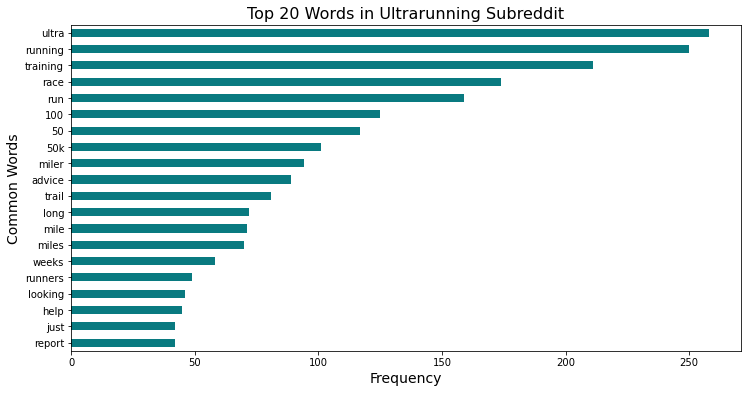

In [104]:
# Top 20 occurring words in Ultrarunning subreddit

df_ultrarunning.sum(numeric_only=True).sort_values(ascending=True).tail(20).plot.barh(figsize=(12,6), color = '#097a80')
plt.xlabel('Frequency', fontdict= {'fontsize':14})
plt.ylabel('Common Words', fontdict= {'fontsize':14})
plt.title('Top 20 Words in Ultrarunning Subreddit', fontdict = {'fontsize':16})
plt.savefig("../graphics/Top_20_words_Ultrarunning.jpg", bbox_inches="tight", dpi=100); #save as jpg